In [1]:
import glob
import numpy as np
import math
import cv2
from cv2 import aruco
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pprint as pp
import pprint as pp

In [2]:
def getVectorFromDic(idx0,idx1):
    return marker_dict[idx0]["tvec"] - marker_dict[idx1]["tvec"]

# idx0: origin
def getAngleFromDic(idx1,idx0,idx2):
    return getAngle(getVectorFromDic(idx2,idx0),getVectorFromDic(idx1,idx0))

def getDistanceFromDic(idx0,idx1):
     return np.linalg.norm(getVectorFromDic(idx0,idx1))
def getJointVec(arr,joint_num):
    return np.array(arr[joint_num*4:joint_num*4+3])

def normalization(vec):
    return vec/np.linalg.norm(vec)

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def getAngle(v1, v2):
    return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))

# Get Camera Parameters

In [3]:
parameter_dir=r"I:\20200720_FloorDetection\camera_parameter\2camera"

#load xml file
camera_parameters = {}
# camera_idxs = ["18284509","18284511","18284512"]
camera_idxs = ["18284509"]

parameter_types = ["CameraMatrix","Intrinsics","Distortion"]


for camera_idx in camera_idxs:
    fileToLoad = os.path.join(parameter_dir,camera_idx+".xml")
    fs = cv2.FileStorage(fileToLoad, cv2.FILE_STORAGE_READ)
    _camera_parameter = {}
    for parameter_type in parameter_types:
        _camera_parameter[parameter_type] = fs.getNode(parameter_type).mat()
        camera_parameters[camera_idx] = _camera_parameter

#3d points to image (2nd image)
extri = [0]*3
intri  = [0]*3
dist = [0]*3

for i in range(len(camera_idxs)):
    rotation_matrix = camera_parameters[camera_idxs[i]][parameter_types[0]][:,0:3]
    rvec,_ = cv2.Rodrigues(rotation_matrix)
    tvec = camera_parameters[camera_idxs[i]][parameter_types[0]][:,3]
    
    extri[i] = camera_parameters[camera_idxs[i]][parameter_types[0]]
    intri[i] = camera_parameters[camera_idxs[i]][parameter_types[1]]
    dist[i] = camera_parameters[camera_idxs[i]][parameter_types[2]]

In [4]:
camera_index = 0

mtx = camera_parameters[camera_idxs[camera_index]][parameter_types[1]]
dist = camera_parameters[camera_idxs[camera_index]][parameter_types[2]]

In [5]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
length_of_axis = 0.09
markerLength = 0.18

white_background  = np.full((1024, 1280, 3),255)

image_data = r"I:\20200721_Aruco\Capture01\000000000000_rendered.png"
frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# frame_markers = aruco.drawDetectedMarkers(white_background.copy(), corners, ids)

rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# imaxis = aruco.drawDetectedMarkers(white_background.copy(), corners, ids)

    
for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
    
# Marker data to dictionary
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    _vecs["corner"] = corners[idx][0]
    marker_dict[marker_index] = _vecs
print("tvecs and rvecs for each marker\n")
pp.pprint(marker_dict)


tvecs and rvecs for each marker

{0: {'corner': array([[774., 718.],
       [842., 705.],
       [873., 736.],
       [801., 750.]], dtype=float32),
     'rvec': array([ 1.8620094 , -0.29306587,  0.1434418 ]),
     'tvec': array([0.46935424, 0.55845221, 3.62751887])},
 1: {'corner': array([[832., 786.],
       [906., 771.],
       [940., 807.],
       [862., 825.]], dtype=float32),
     'rvec': array([ 1.8665345 , -0.27913831,  0.10837229]),
     'tvec': array([0.56512431, 0.66202203, 3.28680261])},
 2: {'corner': array([[ 965.,  758.],
       [1034.,  741.],
       [1073.,  776.],
       [1001.,  793.]], dtype=float32),
     'rvec': array([ 1.86662509, -0.2907723 ,  0.11563864]),
     'tvec': array([0.87310507, 0.61008225, 3.32277176])},
 3: {'corner': array([[900., 694.],
       [963., 680.],
       [995., 708.],
       [929., 723.]], dtype=float32),
     'rvec': array([ 1.86146699, -0.29388176,  0.09350187]),
     'tvec': array([0.80481406, 0.52417667, 3.79243766])},
 4: {'corner': 

<Figure size 432x288 with 0 Axes>

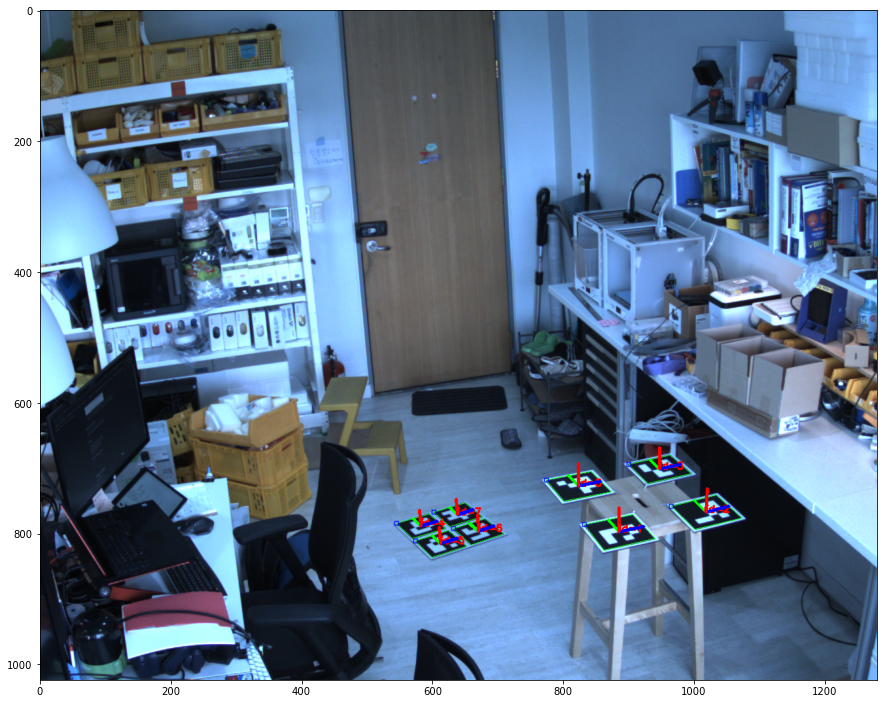

In [11]:
# def annotateDistanceFromDic(idx0,idx1):

def getCenterOnImageFromDic(idx):
    return np.average(marker_dict[idx]["corner"],axis = 0)

plt.figure()
plt.figure(figsize=(15,15))
plt.imshow(imaxis)
plt.show()

<Figure size 432x288 with 0 Axes>

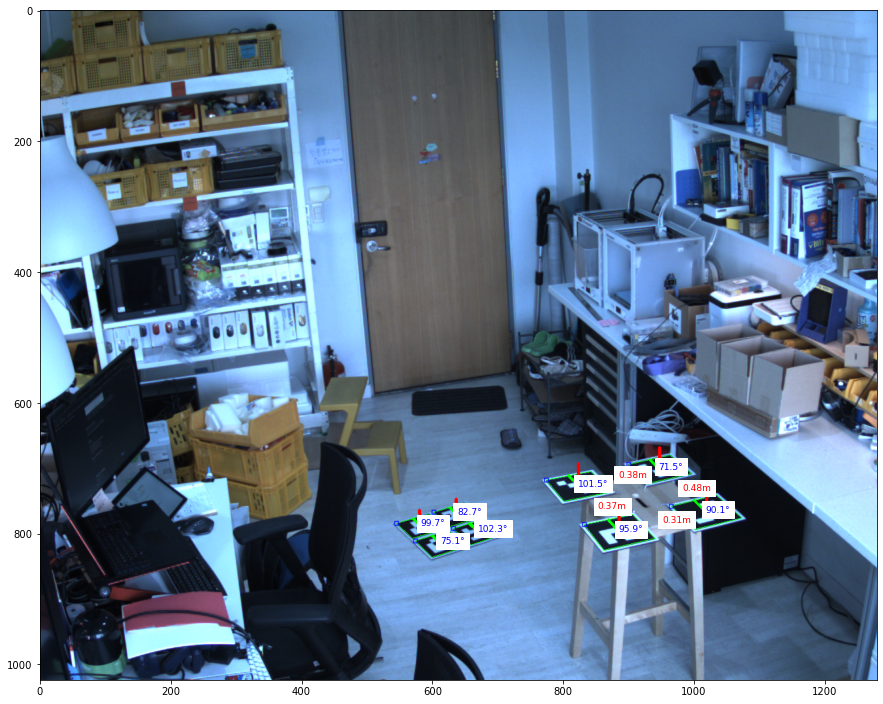

In [14]:
# def annotateDistanceFromDic(idx0,idx1):

def getCenterOnImageFromDic(idx):
    return np.average(marker_dict[idx]["corner"],axis = 0)

plt.figure()
plt.figure(figsize=(15,15))


#Actual Distance: 0.32m 0.36m
for idx0,idx1 in [[0,1],[1,2],[2,3],[3,0]]:
    cen_x, cen_y = np.average([getCenterOnImageFromDic(idx0),getCenterOnImageFromDic(idx1)],axis = 0)
    distance = getDistanceFromDic(idx0,idx1)
    text = plt.text(int(cen_x), int(cen_y), "{:.2f}m".format(distance), fontsize=9,color = "red")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    

for idx1,idx0,idx2 in [[0,1,2],[1,2,3],[2,3,0],[3,0,1]]:
    x,y = getCenterOnImageFromDic(idx0)
    angle = getAngleFromDic(idx1,idx0,idx2)
    text = plt.text(int(x), int(y), "{:.1f}°".format(angle), fontsize=9,color = "blue")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    

for idx1,idx0,idx2 in [[4,5,6],[5,6,7],[6,7,4],[7,4,5]]:
    x,y = getCenterOnImageFromDic(idx0)
    angle = getAngleFromDic(idx1,idx0,idx2)
    text = plt.text(int(x), int(y), "{:.1f}°".format(angle), fontsize=9,color = "blue")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


plt.imshow(imaxis)
plt.show()